In [1]:
import dvv_module
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import datetime
from statistics import mean

region = "TURKEY"
stack_n = "10"
stack_n_ = stack_n
if stack_n == "5": stack_n_ ="05"
compo_ = "ZZ"
net1   = "KO"
sta1_  = "GAZ"
net2   = "KO"
sta2_  = "KMRS"
filt_  = "0.1_1.0"

""" Define parameters"""
##RIDGECREST, ##TURKEY, ##AEGEAN
input_file = "../"+region+"/CC/"+sta1_+"_"+sta2_+"/ToNoisePy_"+stack_n+"days/"+net1+"_"+sta1_+"_"+net2+"_"+sta2_+"_comp_"+compo_+"_filt"+filt_+"_stack0"+stack_n_+".npy"
output_dir = "../"+region+"/stretching/"+sta1_+"_"+sta2_+"/"+stack_n+"days_stack"  # Output directory for figures

#EQtime = UTCDateTime("2019-07-06T03:24:58") #Ridgecrest
#EQmag  = 7.1 #Ridgecrest
EQtime = UTCDateTime("2023-02-06T01:17:34") #Turkey
EQmag  = 7.8 #Turkey
#EQtime = UTCDateTime("2014-05-24T09:25:02") #Aegean
#EQmag  = 6.9 #Aegean
vertical_line_date = pd.to_datetime("2014-05-24")

# Define reference stack start-end time
#AEGEAN ref_start_end = "2014-02-20","2014-05-23" #LIA_SMTH  
#tref_start_str = "2014-02-20" #AEGEAN
#tref_end_str =  "2014-05-23"
#TURKEY ref_start_end = "2022-10-21","2023-02-05" GAZ_KMRS
tref_start_str = "2022-10-21" #TURKEY
tref_end_str =  "2023-02-05"
#tref_start_str = "2018-11-01" #RIDGECREST 
#tref_end_str =  "2019-07-05" #ALL #RIDGECREST "2019-03-05" # 4M , "2019-05-05" # 6M ,"2019-01-05" # 2M 
tref_start = np.datetime64(tref_start_str)
tref_end = np.datetime64(tref_end_str)

# parameters for stretching method
dvv_max   = 0.01 # absolute bound for the velocity variation;
nbtrial   = 50   # number of increment of dt [-epsilon,epsilon] for the streching
cc_thresh = 0.1

vmin = 2 # minimum direct velocity km/s
dist = 46 #GAZ_KMRS
lwin = 60 # coda window length in s
twin = [dist/vmin, (dist/vmin)+lwin] 
dpi=300

#inter-station distances in km
#RIDGECREST
#48 #CI.CCC_CI.TOW2, #13 #CI.SRT_CI.TOW2, 15 #CI.CLC_CI.TOW2, 19 #CI.CLC_CI.SRT, 40 #CI.CCC_CI.SRT, 39 #CI.CCC_CI.CLC, 19 #CI.CLC_CI.SRT
#TURKIYE
#46 #KO.GAZ_KO.KMRS, #170 #KO.KMRS_KO.URFA, 146 #KO.GAZ_KO.URFA, 172 #KO.DARE_KO.URFA, #128 #KO.DARE_KO.KMRS, #157 #KO.DARE_KO.GAZ
#AEGEAN
#70 #HL.LIA_HL.SMTH, 80 #HL.SMTH_KO.GELI, 123 #HL.LIA_KO.GELI, 142 #HT.SIGR_KO.GELI, 95 #HL.LIA_HT.SIGR, 142 #HL.SMTH_HT.SIGR

Station pair: KO.GAZ - KO.KMRS


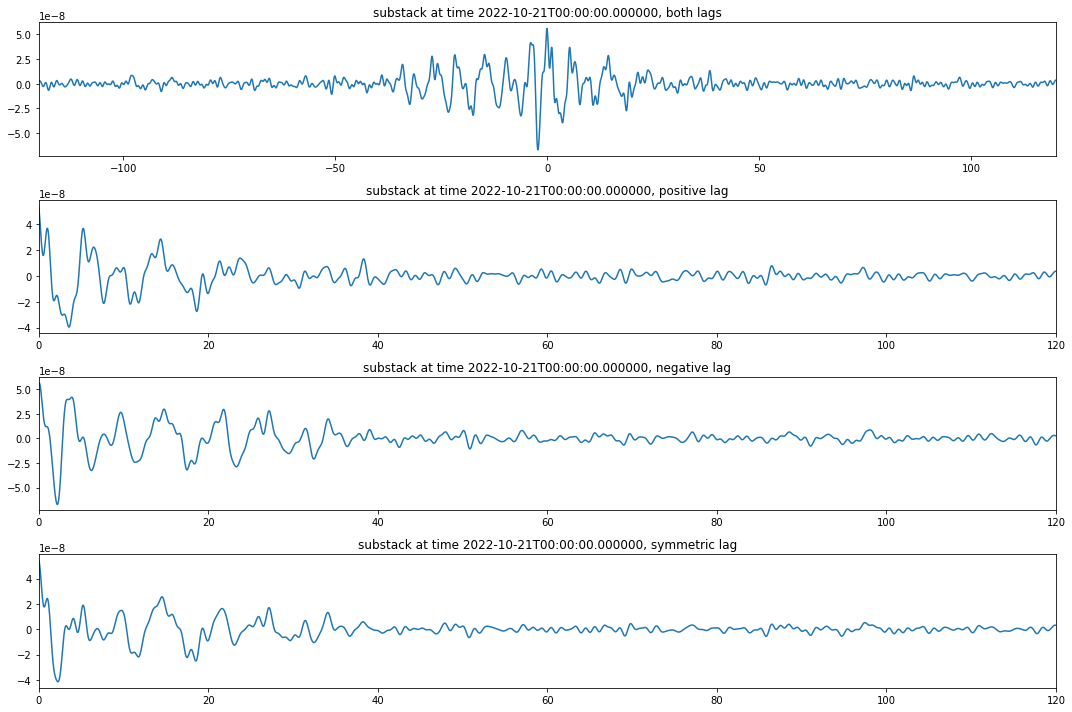

['2022-10-31T00:00:00.000000' '2022-11-01T00:00:00.000000'
 '2022-11-02T00:00:00.000000' '2022-11-03T00:00:00.000000'
 '2022-11-04T00:00:00.000000' '2022-11-05T00:00:00.000000'
 '2022-11-06T00:00:00.000000' '2022-11-07T00:00:00.000000'
 '2022-11-08T00:00:00.000000' '2022-11-09T00:00:00.000000'
 '2022-11-10T00:00:00.000000' '2022-11-11T00:00:00.000000'
 '2022-11-12T00:00:00.000000' '2022-11-13T00:00:00.000000'
 '2022-11-14T00:00:00.000000' '2022-11-15T00:00:00.000000'
 '2022-11-16T00:00:00.000000' '2022-11-17T00:00:00.000000'
 '2022-11-18T00:00:00.000000' '2022-11-19T00:00:00.000000'
 '2022-11-20T00:00:00.000000' '2022-11-21T00:00:00.000000'
 '2022-11-22T00:00:00.000000' '2022-11-23T00:00:00.000000'
 '2022-11-24T00:00:00.000000' '2022-11-25T00:00:00.000000'
 '2022-11-26T00:00:00.000000' '2022-11-27T00:00:00.000000'
 '2022-11-28T00:00:00.000000' '2022-11-29T00:00:00.000000'
 '2022-11-30T00:00:00.000000' '2022-12-01T00:00:00.000000'
 '2022-12-02T00:00:00.000000' '2022-12-03T00:00:00.00000

In [2]:
""" Extract data from npy and prepare it"""

# Get station names from file name
dum = os.path.split(input_file)[1].split("_stacks")[0].split("_")
sta1 = f"{dum[0]}.{dum[1]}"
sta2 = f"{dum[2]}.{dum[3]}"
print(f"Station pair: {sta1} - {sta2}")

# Read file
data = np.load(input_file, allow_pickle=True)
ndata = data["CCdata"].T
tlag_all = data["tlag"]
timestamp = data["times"].astype(np.datetime64)
timestamp = timestamp[:]

sampling_rate = data["sampling_rate"]
fmin   = data["fmin"]
fmax   = data["fmax"]
comp   = data["comp"]
maxlag = data["maxlag"]
#stack  = 5 #data["stack"]
stack  = data["stack"]

# Define new substack length and step
stacklen_new = np.timedelta64(int(stack), "D") #5
step = np.timedelta64(1, "D")

#dist = data["dist"]
npts_all = ndata.shape[1]
npts = npts_all//2
tlag = tlag_all[npts:]
ndata_pos = ndata[:, npts:]  # positive lag
ndata_neg = np.fliplr(ndata[:, :npts + 1])  # negative lag
ndata_sym = np.mean(np.vstack((ndata_pos[np.newaxis], ndata_neg[np.newaxis])), axis=0)
twin_indx = np.where((tlag >= np.min(twin)) & (tlag < np.max(twin)))[0]
npts_win = len(twin_indx)

#Plot positive, negative and symmetric lags for 1st row
plot_lags = True
if plot_lags == True:
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    ix = 0
    ax[0].plot(tlag_all, ndata[ix, :])
    ax[0].set_title(f"substack at time {timestamp[0]}, both lags")
    ax[0].set(xlim=(-maxlag,maxlag))
    ax[1].plot(tlag, ndata_pos[ix, :])
    ax[1].set_title(f"substack at time {timestamp[0]}, positive lag")
    ax[2].plot(tlag, ndata_neg[ix, :])
    ax[2].set_title(f"substack at time {timestamp[0]}, negative lag")
    ax[3].plot(tlag, ndata_sym[ix, :])
    ax[3].set_title(f"substack at time {timestamp[0]}, symmetric lag")
    for a in ax[1:]:
        a.set(xlim=(0,tlag[-1]))
    plt.tight_layout()
    plt.show()

# Get reference stack
iref = np.where((timestamp > tref_start) & (timestamp < tref_end))[0]
refstack = np.mean(ndata[iref, :], axis=0)
refstack_pos = np.mean(ndata_pos[iref, :], axis=0)
refstack_neg = np.mean(ndata_neg[iref, :], axis=0)
refstack_sym = np.mean(ndata_sym[iref, :], axis=0)

# Change substack length
_, ndata = dvv_module.change_substack_length(timestamp, ndata, stacklen_new, step, dt=1/sampling_rate)
_, ndata_sym = dvv_module.change_substack_length(timestamp, ndata_sym, stacklen_new, step, dt=1/sampling_rate)
_, ndata_pos = dvv_module.change_substack_length(timestamp, ndata_pos, stacklen_new, step, dt=1/sampling_rate)
timestamp, ndata_neg = dvv_module.change_substack_length(timestamp, ndata_neg, stacklen_new, step, dt=1/sampling_rate)

start_date = pd.to_datetime(min(timestamp)) 
end_date= pd.to_datetime(max(timestamp)) 
date_range = pd.date_range(start=start_date, end=end_date) 
num_days = len(date_range) #FM
print(timestamp)

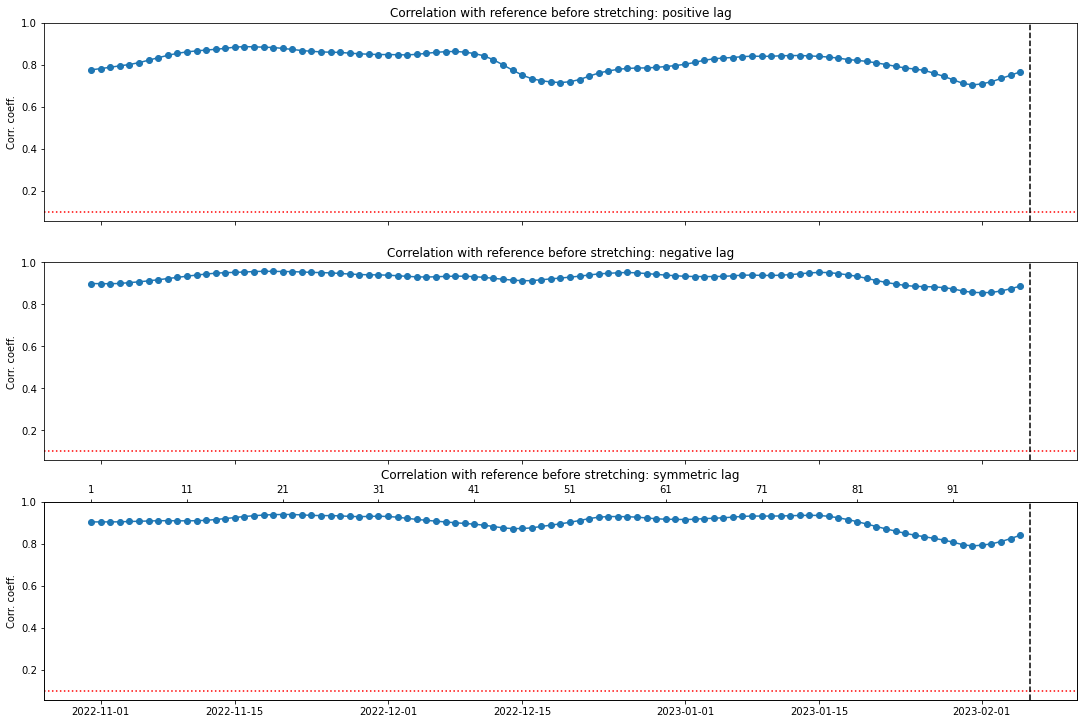

In [3]:
# Get correlation coefficient between substack and reference (before stretching)
nwin = ndata_sym.shape[0]
cc_pos = np.zeros(shape=(nwin,), dtype=np.float32)
cc_neg = np.zeros(shape=(nwin,), dtype=np.float32)
cc_sym = np.zeros(shape=(nwin,), dtype=np.float32)
for iwin in range(nwin):
    cc_pos[iwin] = np.corrcoef(refstack_pos[twin_indx], ndata_pos[iwin, twin_indx])[0, 1]
    cc_neg[iwin] = np.corrcoef(refstack_neg[twin_indx], ndata_neg[iwin, twin_indx])[0, 1]
    cc_sym[iwin] = np.corrcoef(refstack_sym[twin_indx], ndata_sym[iwin, twin_indx])[0, 1]
    

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15,10))

ax[0].plot(timestamp, cc_pos, marker="o")
#ax[0].plot(range(1, num_days - stack), cc_pos, marker="o")
ax[0].axhline(cc_thresh, c="r", ls=":")
ax[0].axvline(EQtime._get_datetime(), c="k", ls="--")
ax[0].set_title("Correlation with reference before stretching: positive lag")
ax[1].plot(timestamp, cc_neg, marker="o")
#ax[1].plot(range(1, num_days - stack), cc_neg, marker="o")
ax[1].axhline(cc_thresh, c="r", ls=":")
ax[1].axvline(EQtime._get_datetime(), c="k", ls="--")
ax[1].set_title("Correlation with reference before stretching: negative lag")
ax[2].plot(timestamp, cc_sym, marker="o")
#ax[2].plot(range(1, num_days - stack), cc_sym, marker="o")
ax[2].axhline(cc_thresh, c="r", ls=":")
ax[2].axvline(EQtime._get_datetime(), c="k", ls="--")
ax[2].set_title("Correlation with reference before stretching: symmetric lag")

for a in ax:
    a.set(ylabel="Corr. coeff.")

# Creating a second x-axis for day numbers
ax3 = ax[2].twiny()
#ax3.set_xlabel('Day Number of the Experiment')
ax3.set_xlim(ax[2].get_xlim())  # Set the same limits as the first x-axis
ax3_day_numbers = np.arange(1, num_days +1, 10)  # Day numbers at intervals of 10 days
ax3_date_numbers = date_range[ax3_day_numbers - 1]  # Corresponding dates
ax3.set_xticks(ax3_date_numbers)  # Set x-ticks to match the dates
ax3.set_xticklabels(ax3_day_numbers)  # Set corresponding day numbers

plt.tight_layout(pad=0.5)

plt.show()

In [4]:
# # Print variables
%whos  

Variable             Type             Data/Info
-----------------------------------------------
EQmag                float            7.8
EQtime               UTCDateTime      2023-02-06T01:17:34.000000Z
UTCDateTime          type             <class 'obspy.core.utcdatetime.UTCDateTime'>
a                    AxesSubplot      AxesSubplot(0.0388889,0.0305556;0.956481x0.275)
ax                   ndarray          3: 3 elems, type `object`, 24 bytes
ax3                  AxesSubplot      AxesSubplot(0.0388889,0.0305556;0.956481x0.275)
ax3_date_numbers     DatetimeIndex    DatetimeIndex(['2022-10-3<...>tetime64[ns]', freq=None)
ax3_day_numbers      ndarray          10: 10 elems, type `int64`, 80 bytes
cc_neg               ndarray          98: 98 elems, type `float32`, 392 bytes
cc_pos               ndarray          98: 98 elems, type `float32`, 392 bytes
cc_sym               ndarray          98: 98 elems, type `float32`, 392 bytes
cc_thresh            float            0.1
comp                 n

../TURKEY/stretching/GAZ_KMRS/10days_stack/GAZ-KMRS_10days_REF_CGF.pdf


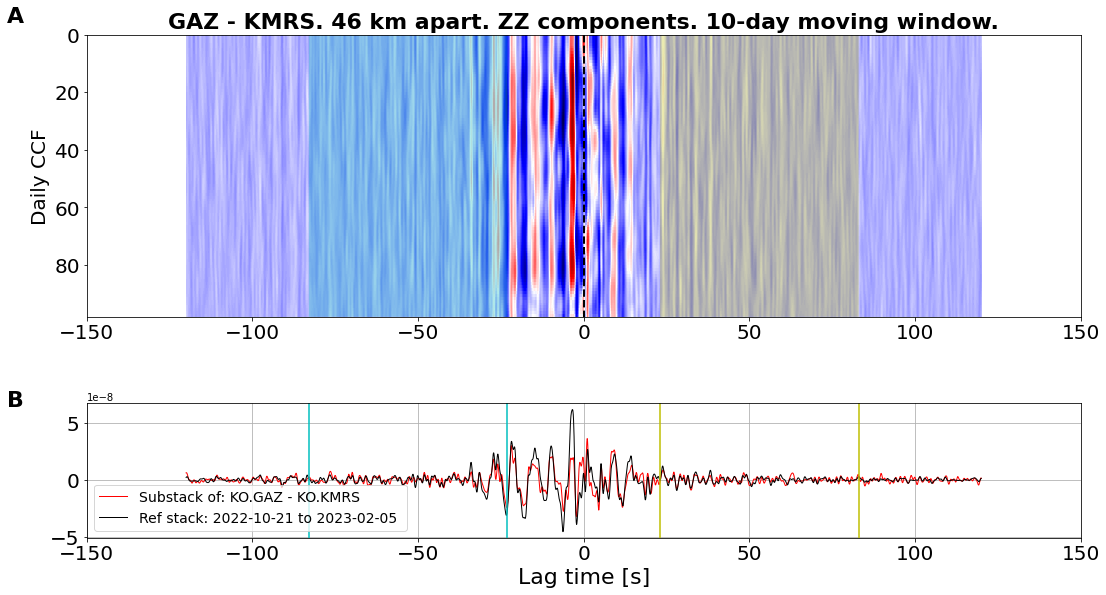

In [5]:
""" Plot cross correlation and the time window """

plt.figure(figsize=(15,15))
ax0 = plt.subplot(311)
# 2D waveform matrix
ax0.matshow(ndata,cmap='seismic',extent=[tlag_all[0],tlag_all[-1],nwin,0],aspect='auto')
ax0.set_ylabel(f"Daily CCF", size='20')
ax0.set_title(f"{sta1[3:]} - {sta2[3:]}. {dist} km apart. {compo_} components. {stack_n}-day moving window.", size='22', fontweight='bold')
ax0.plot([0,0],[0,nwin],'k--',linewidth=2)
ax0.tick_params(axis='x', labelcolor='k', labelsize='20')
ax0.tick_params(axis='y', labelcolor='k', labelsize='20')
ax0.set_xlim(-150,150)
# shade the coda part
nwin_indx = np.where((tlag_all <= -np.min(twin)) & (tlag_all > -np.max(twin)))[0] # negative lag time indices for dvv window
pwin_indx = np.where((tlag_all >= np.min(twin)) & (tlag_all < np.max(twin)))[0] # positive lag time indices for dvv window
ax0.fill(np.concatenate((tlag_all[nwin_indx],np.flip(tlag_all[nwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'c', alpha=0.3,linewidth=1)
ax0.fill(np.concatenate((tlag_all[pwin_indx],np.flip(tlag_all[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'y', alpha=0.3)
ax0.xaxis.set_ticks_position('bottom')
ax0.text(-0.08, 1.1, 'A', transform=ax0.transAxes, fontsize=22, fontweight='bold', va='top')

# reference waveform
ax1 = plt.subplot(613)
ax1.plot(tlag_all,ndata[-1, :],'r-',linewidth=1)
ax1.plot(tlag_all,refstack,'k-',linewidth=1)
ax1.set_xlabel('Lag time [s]', size='22', color='black')
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.tick_params(axis='x', labelcolor='k', labelsize='20')
ax1.tick_params(axis='y', labelcolor='k', labelsize='20')
ax1.set_xlim(-150,150)
#ax1.set_ylim(-4.0e-8,4.0e-8)
ax1.grid(True)
ax1.legend([f"Substack of: {sta1} - {sta2}", f"Ref stack: {tref_start_str} to {tref_end_str} ",\
            "analysis window"],loc='lower left', fontsize="14")
ax1.axvline(tlag_all[nwin_indx[0]], c="c")
ax1.axvline(tlag_all[nwin_indx[-1]], c="c")
ax1.axvline(tlag_all[pwin_indx[0]], c="y")
ax1.axvline(tlag_all[pwin_indx[-1]], c="y")
ax1.text(-0.08, 1.1, 'B', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top')

#plt.tight_layout(pad=0.7)
output_file = os.path.join(output_dir, f"{sta1[3:]}-{sta2[3:]}_{stack_n}days\
_REF_CGF.pdf")
print(output_file)
plt.tight_layout(pad=0.0)
#plt.savefig(output_file, format="PDF", dpi=dpi, bbox_inches='tight')

plt.show()
plt.close()

In [6]:
""" Apply the stretching function 
def stretching(ref, cur, dv_range, nbtrial, para):
    This function compares the Reference waveform to stretched/compressed current waveforms to get the relative seismic velocity variation (and associated error).
    It also computes the correlation coefficient between the Reference waveform and the current waveform.

    PARAMETERS:
    ----------------
    ref: Reference waveform (np.ndarray, size N)
    cur: Current waveform (np.ndarray, size N)
    dv_range: absolute bound for the velocity variation; example: dv=0.03 for [-3,3]% of relative velocity change ('float')
    nbtrial: number of stretching coefficient between dvmin and dvmax, no need to be higher than 100  ('float')
    para: vector of the indices of the cur and ref windows on wich you want to do the measurements 
    (np.ndarray, size tmin*delta:tmax*delta)
    For error computation, we need parameters:
        fmin: minimum frequency of the data
        fmax: maximum frequency of the data
        tmin: minimum time window where the dv/v is computed
        tmax: maximum time window where the dv/v is computed
    RETURNS: dv, error, cc, cdp
    ----------------
    dv: Relative velocity change dv/v (in %)
    error: Errors in the dv/v measurements based on Weaver et al (2011), On the precision of noise-correlation interferometry, Geophys. J. Int., 185(3)
    cc: correlation coefficient between the reference waveform and the best stretched/compressed current waveform
    cdp: correlation coefficient between the reference waveform and the initial current waveform    

    Note: The code first finds the best correlation coefficient between the Reference waveform and the stretched/compressed current waveform among the "nbtrial" values.
    A refined analysis is then performed around this value to obtain a more precise dv/v measurement .
"""

param  = {
    'freq':[fmin,fmax], # frequency of bandpass filter applied to stacks
    'twin': twin,  # start-end of time window in s
    'dt': 1/sampling_rate,  # sampling interval in s
    't': tlag  # vector of lag time
}

# allocate matrix for dvv and its uncertainty
dvv_stretch = np.empty(shape=(nwin,6),dtype=np.float32)
ccafter_stretch = np.empty(shape=(nwin,3),dtype=np.float32)

dvv_stretch[:] = np.nan
ccafter_stretch[:] = np.nan

# loop through each substack window
for iwin in range(nwin):
    
    # symmetric, casual and acausal lags for both ref and current waveform
    pcur = ndata_pos[iwin,twin_indx]   # substack, positive lag
    ncur = ndata_neg[iwin,twin_indx]   # substack, negative lag
    scur = ndata_sym[iwin,twin_indx]   # substack, symmetric lag
    pref = refstack_pos[twin_indx]  # reference, positive lag
    nref = refstack_neg[twin_indx]  # reference, negative lag
    sref = refstack_sym[twin_indx]  # reference, symmetric lag
    
    if cc_pos[iwin] >= cc_thresh: # Only keep substack if correlation coefficient before stretching above threshold
        dvv, error,ccafter_pos,cdp_pos = dvv_module.stretching_vect(pref,pcur,dvv_max,nbtrial,param)        
        #print(f"window {timestamp[iwin]} pos lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        print(f"window {timestamp[iwin]} positive lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        dvv_stretch[iwin,0],dvv_stretch[iwin,1] = dvv, error
        ccafter_stretch[iwin,0] = ccafter_pos
    if cc_neg[iwin] >= cc_thresh:
        dvv, error,ccafter_neg,cdp_neg = dvv_module.stretching_vect(nref,ncur,dvv_max,nbtrial,param)        
        #print(f"window {timestamp[iwin]} neg lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        print(f"window {timestamp[iwin]} negative lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        dvv_stretch[iwin,2],dvv_stretch[iwin,3] = dvv, error        
        #ccafter_stretch[iwin,1] = ccafter_pos
        ccafter_stretch[iwin,1] = ccafter_neg
    if cc_sym[iwin] >= cc_thresh:
        dvv, error,ccafter_sym,cdp_sym = dvv_module.stretching_vect(sref,scur,dvv_max,nbtrial,param)        
        #print(f"window {timestamp[iwin]} sym lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        print(f"window {timestamp[iwin]} sym lag: dv/v = {dvv:.2f}, error = {error:.2f}")
        dvv_stretch[iwin,4],dvv_stretch[iwin,5] = dvv, error        
        #ccafter_stretch[iwin,2] = ccafter_pos
        ccafter_stretch[iwin,2] = ccafter_sym
    #print(dvv_stretch[iwin,:])

window 2022-10-31T00:00:00.000000 positive lag: dv/v = 0.03, error = 0.05
window 2022-10-31T00:00:00.000000 negative lag: dv/v = -0.05, error = 0.03
window 2022-10-31T00:00:00.000000 sym lag: dv/v = -0.05, error = 0.03
window 2022-11-01T00:00:00.000000 positive lag: dv/v = 0.03, error = 0.04
window 2022-11-01T00:00:00.000000 negative lag: dv/v = -0.05, error = 0.03
window 2022-11-01T00:00:00.000000 sym lag: dv/v = -0.05, error = 0.03
window 2022-11-02T00:00:00.000000 positive lag: dv/v = 0.03, error = 0.04
window 2022-11-02T00:00:00.000000 negative lag: dv/v = -0.04, error = 0.03
window 2022-11-02T00:00:00.000000 sym lag: dv/v = -0.05, error = 0.03
window 2022-11-03T00:00:00.000000 positive lag: dv/v = 0.02, error = 0.04
window 2022-11-03T00:00:00.000000 negative lag: dv/v = -0.04, error = 0.03
window 2022-11-03T00:00:00.000000 sym lag: dv/v = -0.05, error = 0.03
window 2022-11-04T00:00:00.000000 positive lag: dv/v = 0.02, error = 0.04
window 2022-11-04T00:00:00.000000 negative lag: dv

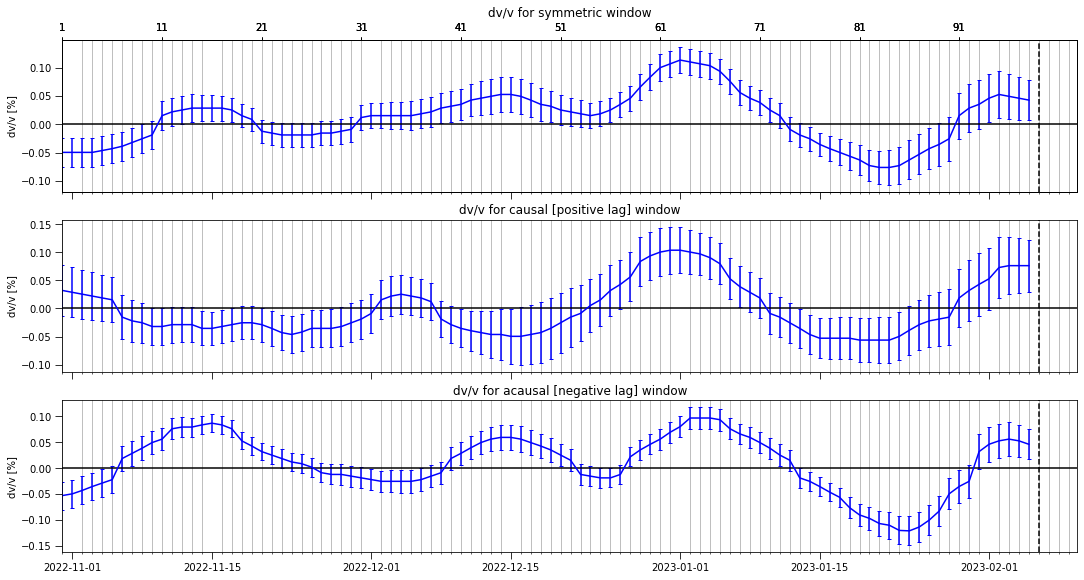

In [7]:
from datetime import datetime
import matplotlib.dates as mdates

t = np.array(timestamp).astype(datetime)
#print(t)
fig, axs = plt.subplots(3,1,sharex=True, sharey=False, figsize=(15,8))
#axs[0].plot(t, dvv_stretch[:,4], marker="o")
axs[0].errorbar(t, dvv_stretch[:,4], yerr=dvv_stretch[:,5], c="b", capsize=2)
axs[0].set_title(f"dv/v for symmetric window")
axs[0].set_xlim(t[0])
#axs[1].plot(t, dvv_stretch[:,0], marker="o")
axs[1].errorbar(t, dvv_stretch[:,0], yerr=dvv_stretch[:,1], c="b", capsize=2)
axs[1].set_title(f"dv/v for causal [positive lag] window")
axs[1].set_xlim(t[0])
#axs[2].plot(t, dvv_stretch[:,2], marker="o")
axs[2].errorbar(t, dvv_stretch[:,2], yerr=dvv_stretch[:,3], c="b", capsize=2)
axs[2].set_title(f"dv/v for acausal [negative lag] window")
axs[2].set_xlim(t[0])

for ax in axs:
    ax.set(ylabel="dv/v [%]")    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(which='major', length=7)
    fmt_day = mdates.DayLocator()
    ax.xaxis.set_minor_locator(fmt_day)
    ax.xaxis.grid(True, which='minor')
    ax.axvline(EQtime._get_datetime(), c="k", ls="--")
    ax.axhline(0, c="k", ls="-")
    
    axs3 = axs[0].twiny()
    axs3.set_xlim(axs[0].get_xlim())
    axs3_day_numbers = np.arange(1, num_days + 1, 10)
    axs3_date_numbers = date_range[axs3_day_numbers - 1]
    axs3.set_xticks(axs3_date_numbers)  
    axs3.set_xticklabels(axs3_day_numbers)
        
plt.tight_layout(pad=0.5)

plt.show()
plt.close()


### dvv_stretch[:,0]

the dv/v SD of this time period is 0.02616331993227767
0.026113264


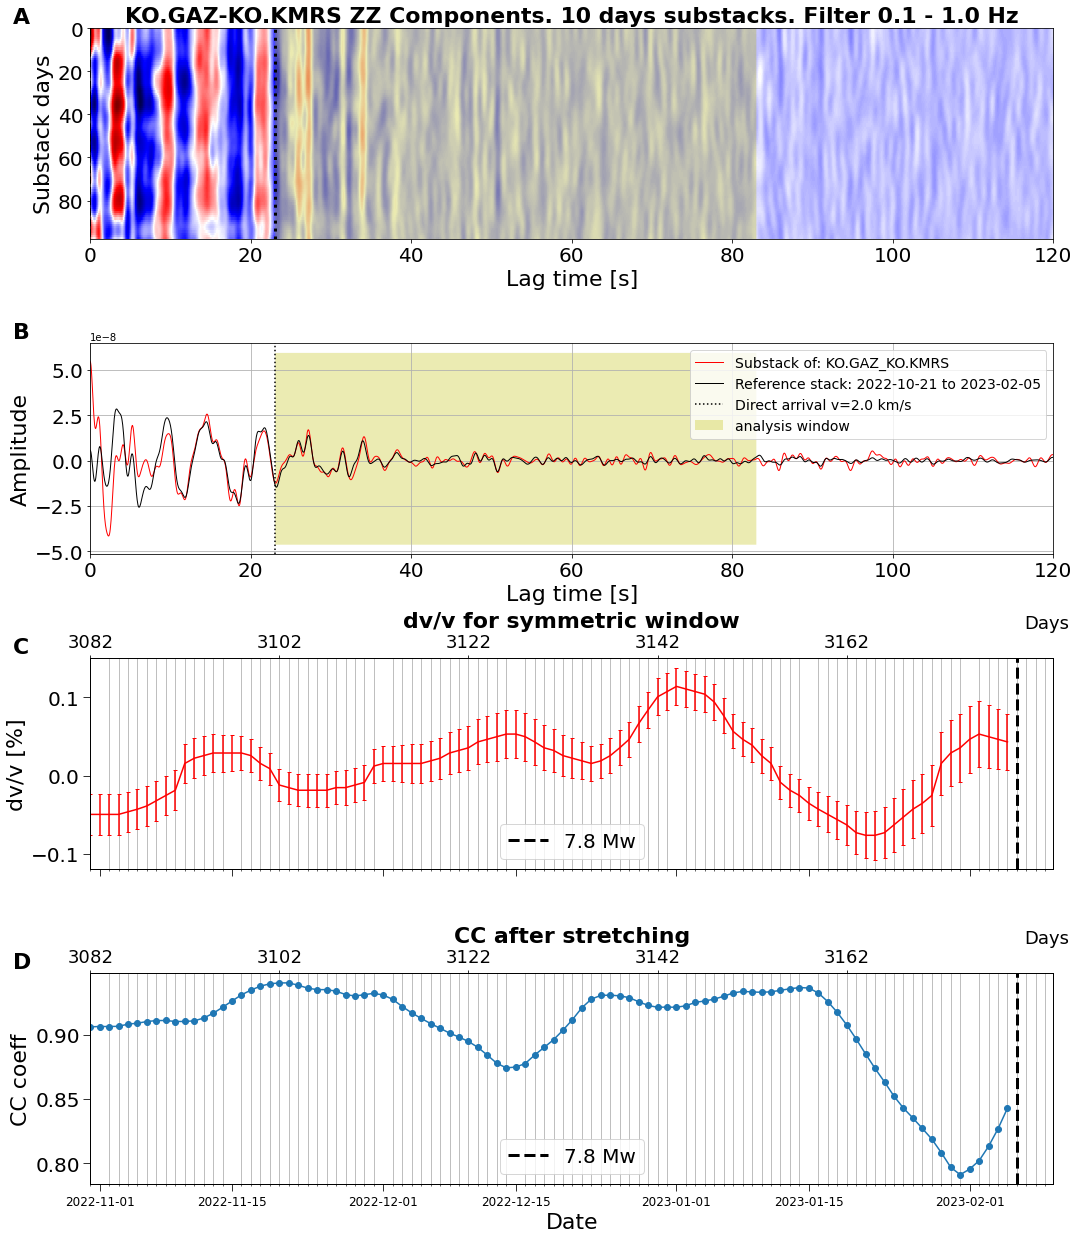

In [8]:
""" Symmetric lag plot """

plt.figure(figsize=(15,25))

ax0= plt.subplot(612)
ax0.matshow(ndata_sym,cmap='seismic',extent=[tlag[0],tlag[-1],nwin,0],aspect='auto')
ax0.set_xlabel("Lag time [s]", size=22)
ax0.set_ylabel(f"Substack days", size=22) 
ax0.set_title(f"{sta1}-{sta2} {str(comp)} Components. {str(stacklen_new)} substacks. Filter {str(fmin)} - {str(fmax)} Hz", size=22, fontweight='bold')
ax0.tick_params(axis='y', labelcolor='black', labelsize='20')
ax0.tick_params(axis='x', labelcolor='black', labelsize='20')
ax0.plot([0,0],[0,nwin],'k--',linewidth=2)
# shade the coda part
pwin_indx = np.where((tlag >= np.min(twin)) & (tlag < np.max(twin)))[0] # positive lag time indices for dvv window
ax0.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'y', alpha=0.3)
ax0.xaxis.set_ticks_position('bottom')
ax0.axvline(dist/vmin, c="k", ls=":", lw="3")
ax0.text(-0.08, 1.1, 'A', transform=ax0.transAxes, fontsize=22, fontweight='bold', va='top')

# reference waveform
ax1 = plt.subplot(613)
ax1.plot(tlag, ndata_sym[ix, :],'r-',linewidth=1) #plot the 1st current as an example
ax1.plot(tlag, refstack_sym,'k-',linewidth=1) #plot reference
ax1.set_xlabel("Lag time [s]", size=22)
ax1.set_ylabel("Amplitude", size=22)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='black', labelsize='20')
ax1.tick_params(axis='x', labelcolor='black', labelsize='20')
ax1.axvline(dist/vmin, c="k", ls=":")
ylims = ax1.get_ylim()
ax1.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*ylims[0],np.ones(len(nwin_indx))*ylims[1]),axis=0),'y', alpha=0.3)
ax1.legend([f"Substack of: {sta1}_{sta2}", f"Reference stack: {tref_start_str} to {tref_end_str}", f"Direct arrival v={vmin:.1f} km/s", "analysis window"],loc='upper right', fontsize="14")
ax1.text(-0.08, 1.1, 'B', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top')

# Plot dv/v
ax2 = plt.subplot(614)
ax2.errorbar(t, dvv_stretch[:,4], yerr=dvv_stretch[:,5], c="r", capsize=2)
#calculate SD of a segment
sfrom = 0 # segment from
sto = -1 #segment to
S = [dvv_stretch[:,5][sfrom:sto]] #define time period in days to get standard deviation
for s in S:
    len_ls = len(dvv_stretch[:,5][sfrom:sto])
    SD = sum(s)/len_ls
print("the dv/v SD of this time period is", SD)
print(dvv_stretch[:,5][0])
ax2.set_title(f"dv/v for symmetric window", size=22, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize='20')
ax2.tick_params(axis='x', labelcolor='white', labelsize='20')
ax2.set_ylabel("dv/v [%]", size=22)  
#ax2.set_ylim([-0.3,0.3])
ax2.set_xlim(t[0])
ax2.text(-0.08, 1.1, 'C', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top')

# CC after stretching
ax3 = plt.subplot(615) # (615)
ax3.plot(t, ccafter_stretch[:,2], marker="o")
ax3.set_title(f"CC after stretching", size=22, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='black', labelsize='20')
ax3.tick_params(axis='x', labelcolor='black', labelsize='12')
ax3.set_xlabel('Date', size='22', color='black')
ax3.set_ylabel("CC coeff", size=22)    
ax3.set_xlim(t[0])
ax3.text(-0.08, 1.1, 'D', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top')

for ax in [ax2,ax3]:    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(which='major', length=7)
    fmt_day = mdates.DayLocator()
    #ax.set_xticklabels(size='18')
    ax.xaxis.set_minor_locator(fmt_day)
    ax.xaxis.grid(True, which='minor')
    ax.axvline(EQtime._get_datetime(), c="k", ls="--",lw="3.0", label=f"{str(EQmag)} Mw")
    ax.legend(loc='lower center', fontsize="20")

    # Creating a second x-axis for countdown
    ax4 = ax.twiny()
    ax4.set_xlim(ax.get_xlim())  
    days_before = (date_range - vertical_line_date).days
    ax4_day_numbers = np.where(days_before >= 0, days_before, days_before ) #-1
    ax4.set_xticks(date_range[::20])
    ax4.set_xticklabels(ax4_day_numbers[::20], size='18')
    ax4.text(0.97, 1.21, 'Days', transform=ax4.transAxes, fontsize=18, va='top') 
    ax5 = ax.twiny()
    ax5.set_xlim(ax.get_xlim())  
    ax5.set_xticks([vertical_line_date])
    ax5.set_xticklabels(['0'], size='18')
    
plt.tight_layout(pad=0.7)
plt.show()
plt.close()

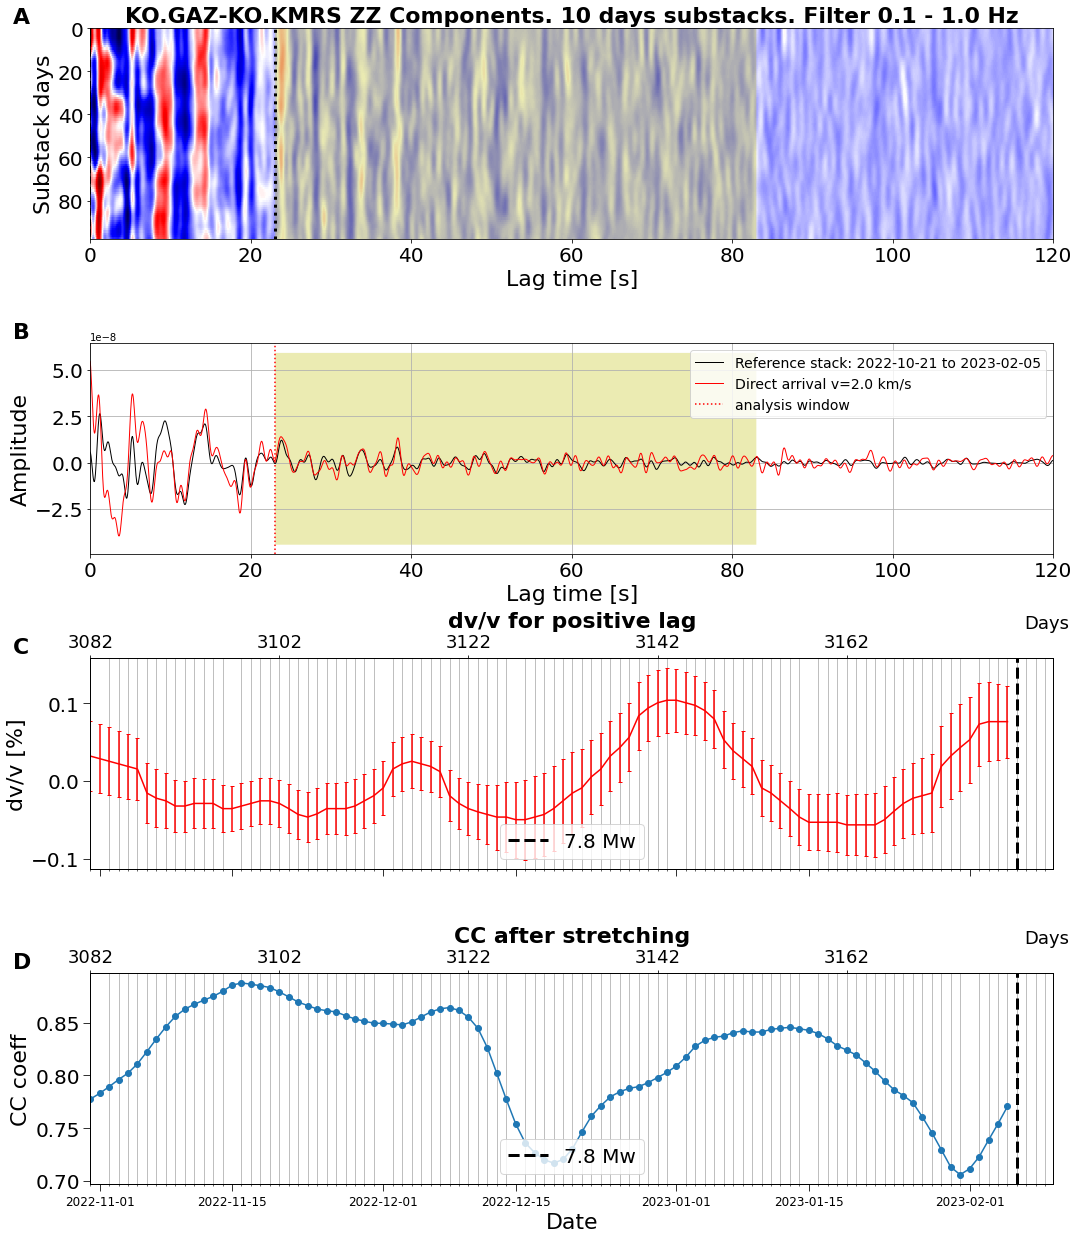

In [9]:
from matplotlib.ticker import FixedLocator
""" Positive lag plot """

plt.figure(figsize=(15,25))
ax0= plt.subplot(612) #311
# 2D waveform matrix
ax0.matshow(ndata_pos,cmap='seismic',extent=[tlag[0],tlag[-1],nwin,0],aspect='auto')
ax0.set_xlabel("Lag time [s]", size=22)
ax0.set_ylabel(f"Substack days", size=22) 
ax0.set_title(f"{sta1}-{sta2} {str(comp)} Components. {str(stacklen_new)} substacks. Filter {str(fmin)} - {str(fmax)} Hz", size=22, fontweight='bold')
ax0.tick_params(axis='y', labelcolor='black', labelsize='20')
ax0.tick_params(axis='x', labelcolor='black', labelsize='20')
ax0.plot([0,0],[0,nwin],'k--',linewidth=2)
# shade the coda part
pwin_indx = np.where((tlag >= np.min(twin)) & (tlag < np.max(twin)))[0] # positive lag time indices for dvv window
ax0.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'y', alpha=0.3)
ax0.xaxis.set_ticks_position('bottom')
ax0.axvline(dist/vmin, c="k", ls=":", lw="3")
ax0.text(-0.08, 1.1, 'A', transform=ax0.transAxes, fontsize=22, fontweight='bold', va='top')

# reference waveform
ax1 = plt.subplot(613)
ax1.plot(tlag,refstack_pos,'k-',linewidth=1)
ax1.plot(tlag, ndata_pos[ix, :],'r-',linewidth=1) #plot the 1st positive current as an example
ax1.set_xlabel("Lag time [s]", size=22)
ax1.set_ylabel("Amplitude", size=22)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='black', labelsize='20')
ax1.tick_params(axis='x', labelcolor='black', labelsize='20')
ax1.axvline(dist/vmin, c="r", ls=":")
ylims = ax1.get_ylim()
ax1.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*ylims[0],np.ones(len(nwin_indx))*ylims[1]),axis=0),'y', alpha=0.3)
ax1.legend([f"Reference stack: {tref_start_str} to {tref_end_str}", f"Direct arrival v={vmin:.1f} km/s", "analysis window"],loc='upper right', fontsize="14")
ax1.text(-0.08, 1.1, 'B', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top')

# Plot dv/v
ax2 = plt.subplot(614)
ax2.errorbar(t, dvv_stretch[:,0], yerr=dvv_stretch[:,1], c="r", capsize=2)
ax2.set_title(f"dv/v for positive lag", size=22, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize='20')
ax2.tick_params(axis='x', labelcolor='white', labelsize='20')
ax2.set_ylabel("dv/v [%]", size=22)
#ax2.axhline(0, c="k", lw=1)
#ax2.set_ylim([-0.3,0.3])
ax2.set_xlim(t[0])
ax2.text(-0.08, 1.1, 'C', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top')

# CC after stretching
ax3 = plt.subplot(615)
ax3.plot(t, ccafter_stretch[:,0], marker="o")
ax3.set_title(f"CC after stretching", size=22, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='black', labelsize='20')
ax3.tick_params(axis='x', labelcolor='black', labelsize='12')
ax3.set_xlabel('Date', size='22', color='black')
ax3.set_ylabel("CC coeff", size=22)    
ax3.set_xlim(t[0])
ax3.text(-0.08, 1.1, 'D', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top')

for ax in [ax2,ax3]:    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(which='major', length=7)
    fmt_day = mdates.DayLocator()
    ax.xaxis.set_minor_locator(fmt_day)
    ax.xaxis.grid(True, which='minor')
    ax.axvline(EQtime._get_datetime(), c="k", ls="--",lw="3.0", label=f"{str(EQmag)} Mw")
    ax.legend(loc='lower center', fontsize="20")    

    # Creating a second x-axis for countdown
    ax4 = ax.twiny()
    ax4.set_xlim(ax.get_xlim())  
    days_before = (date_range - vertical_line_date).days
    ax4_day_numbers = np.where(days_before >= 0, days_before, days_before ) #-1
    # Display the secondary x-axis in intervals of 20 days
    ax4.set_xticks(date_range[::20])
    ax4.set_xticklabels(ax4_day_numbers[::20], size='18')
    ax4.text(0.97, 1.21, 'Days', transform=ax4.transAxes, fontsize=18, va='top')      
    ax5 = ax.twiny()
    ax5.set_xlim(ax.get_xlim())  
    ax5.set_xticks([vertical_line_date])
    ax5.set_xticklabels(['0'], size='18')
    
    
plt.tight_layout(pad=0.7)
plt.show()
plt.close()

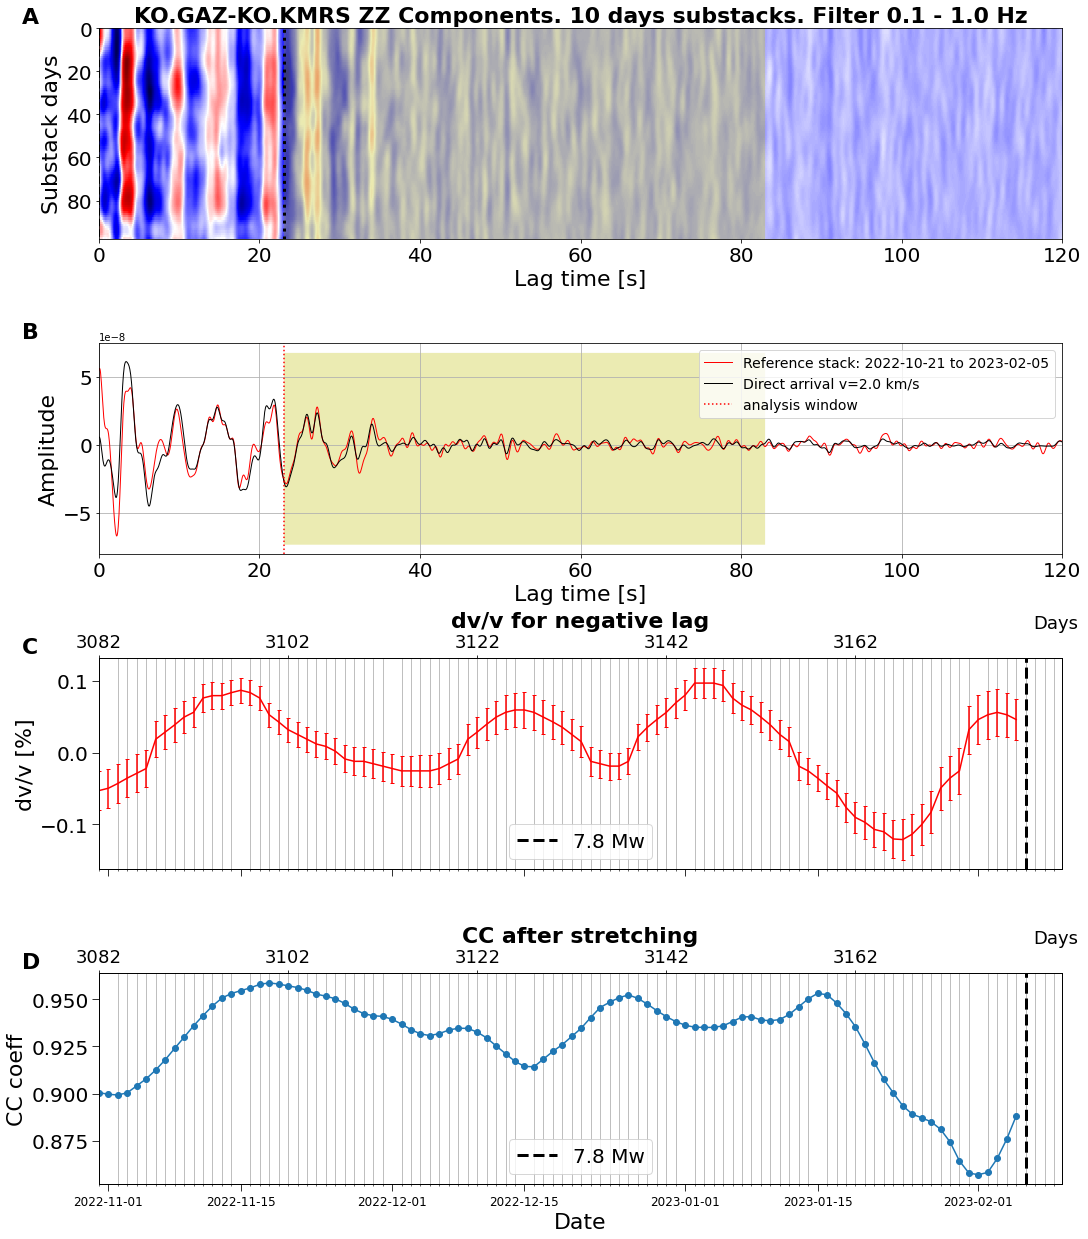

In [10]:
""" Negative lag plot """

plt.figure(figsize=(15,25))
ax0= plt.subplot(612) #311
# 2D waveform matrix
ax0.matshow(ndata_neg,cmap='seismic',extent=[tlag[0],tlag[-1],nwin,0],aspect='auto')
ax0.set_xlabel("Lag time [s]", size=22)
ax0.set_ylabel(f"Substack days", size=22) 
ax0.set_title(f"{sta1}-{sta2} {str(comp)} Components. {str(stacklen_new)} substacks. Filter {str(fmin)} - {str(fmax)} Hz", size=22, fontweight='bold')
ax0.tick_params(axis='y', labelcolor='black', labelsize='20')
ax0.tick_params(axis='x', labelcolor='black', labelsize='20')
ax0.plot([0,0],[0,nwin],'k--',linewidth=2)
# shade the coda part
pwin_indx = np.where((tlag >= np.min(twin)) & (tlag < np.max(twin)))[0] # positive lag time indices for dvv window
ax0.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*0,np.ones(len(nwin_indx))*nwin),axis=0),'y', alpha=0.3)
ax0.xaxis.set_ticks_position('bottom')
ax0.axvline(dist/vmin, c="k", ls=":", lw="3")
ax0.text(-0.08, 1.1, 'A', transform=ax0.transAxes, fontsize=22, fontweight='bold', va='top')

# reference waveform
ax1 = plt.subplot(613)
ax1.plot(tlag, ndata_neg[ix, :],'r-',linewidth=1) #plot the 1st positive current as an example
ax1.plot(tlag,refstack_neg,'k-',linewidth=1)
ax1.set_xlabel("Lag time [s]", size=22)
ax1.set_ylabel("Amplitude", size=22)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='black', labelsize='20')
ax1.tick_params(axis='x', labelcolor='black', labelsize='20')
ax1.axvline(dist/vmin, c="r", ls=":")
ylims = ax1.get_ylim()
ax1.fill(np.concatenate((tlag[pwin_indx],np.flip(tlag[pwin_indx],axis=0)),axis=0), \
    np.concatenate((np.ones(len(nwin_indx))*ylims[0],np.ones(len(nwin_indx))*ylims[1]),axis=0),'y', alpha=0.3)
ax1.legend([f"Reference stack: {tref_start_str} to {tref_end_str}", f"Direct arrival v={vmin:.1f} km/s", "analysis window"],loc='upper right', fontsize="14")
ax1.text(-0.08, 1.1, 'B', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top')

# Plot dv/v
ax2 = plt.subplot(614)
ax2.errorbar(t, dvv_stretch[:,2], yerr=dvv_stretch[:,3], c="r", capsize=2)
ax2.set_title(f"dv/v for negative lag", size=22, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize='20')
ax2.tick_params(axis='x', labelcolor='white', labelsize='20')
ax2.set_ylabel("dv/v [%]", size=22)
#ax2.axhline(0, c="k", lw=1)
#ax2.set_ylim([-0.3,0.3])
ax2.set_xlim(t[0])
ax2.text(-0.08, 1.1, 'C', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top')

# CC after stretching
ax3 = plt.subplot(615)
ax3.plot(t, ccafter_stretch[:,1], marker="o")
ax3.set_title(f"CC after stretching", size=22, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='black', labelsize='20')
ax3.tick_params(axis='x', labelcolor='black', labelsize='12')
ax3.set_xlabel('Date', size='22', color='black')
ax3.set_ylabel("CC coeff", size=22)
ax3.set_xlim(t[0])
ax3.text(-0.08, 1.1, 'D', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top')

for ax in [ax2,ax3]:    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
    ax.tick_params(which='major', length=7)
    fmt_day = mdates.DayLocator()
    ax.xaxis.set_minor_locator(fmt_day)
    ax.xaxis.grid(True, which='minor')
    ax.axvline(EQtime._get_datetime(), c="k", ls="--",lw="3.0", label=f"{str(EQmag)} Mw")
    ax.legend(loc='lower center', fontsize="20")        

    # Creating a second x-axis for countdown
    ax4 = ax.twiny()
    ax4.set_xlim(ax.get_xlim())  
    days_before = (date_range - vertical_line_date).days
    ax4_day_numbers = np.where(days_before >= 0, days_before, days_before ) #-1
    # Display the secondary x-axis in intervals of 20 days
    ax4.set_xticks(date_range[::20])
    ax4.set_xticklabels(ax4_day_numbers[::20], size='18')
    ax4.text(0.97, 1.21, 'Days', transform=ax4.transAxes, fontsize=18, va='top')      
    ax5 = ax.twiny()
    ax5.set_xlim(ax.get_xlim())  # 
    ax5.set_xticks([vertical_line_date])
    ax5.set_xticklabels(['0'], size='18')
   
    
    
#output_file = os.path.join(output_dir, f"{sta1}_{sta2}_stretching_{str(comp)}_{str(stacklen_new).replace(' ','')}\
#_neglag_Filt{str(fmin)}_{str(fmax)}.pdf")
#print(output_file)
plt.tight_layout(pad=0.7)
#plt.savefig(output_file, format="PDF", dpi=dpi, bbox_inches='tight')
   
plt.show()
plt.close()